## Variables à ajouter issues des recherches biblio

Variable(s): 

- Population des pays représentés 
- Variable indiquant si le pays est communiste ou pas 
- Variable indiquant si le pays est stable ou pas 
- Variable indiquant si le pays est émergeant ou pas ( otherwise pauvre , riche à peaufiner par la suite) 
- Variable indiquant si le pays a la culture du sport ou pas. 
- Variable indiquant le PIB par habitant 
- Variable indiquant les financements alloués aux sports (olympiques ou pas)


Il faut créer le train et le test avec des données 2024 , il faut les construire , il faut aussi savoir traiter le fait que cette fois ci la Russie ne sera pas disponible .
Faire indice : pays perturbé 1 avec Russie par exemple ou bien on enlève la Russie  (contexte géopolitique simple, on tah les années où j'ai eu un pb )

But c'est de prédire le nombre de médailles pour chaque pays , indicateur simple 

In [38]:
# !pip install ydata_profiling

In [38] used 0.0 MiB RAM in 0.10s (system mean cpu 2%, single max cpu 8%), peaked 0.0 MiB above final usage, current RAM usage now 416.3 MiB


In [39]:
import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)
from ydata_profiling import ProfileReport
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
import scipy.stats
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

imu.start_watching_memory()



In [39] used 0.0 MiB RAM in 0.10s (system mean cpu 4%, single max cpu 29%), peaked 0.0 MiB above final usage, current RAM usage now 416.3 MiB


# Introduction  (Business Understanding) 

## Détermination objectifs métier , analytique du projet 


Objectifs métiers du projet :

Promotion de la performance sportive : Utiliser les données des Jeux olympiques pour améliorer la performance sportive.

Optimisation des ressources : Identifier les sports les plus prometteurs pour optimiser les investissements sportifs.

Prédiction des tendances : Prédire les performances futures des pays et des athlètes en se basant sur les données historiques.

Analyse de la participation : Analyser la participation mondiale aux Jeux olympiques pour identifier les opportunités de croissance.

-------
Objectifs analytiques du projet :

Analyse des performances : Évaluer les performances des pays, des équipes et des athlètes aux Jeux olympiques.

Identification des facteurs de réussite : Identifier les clés du succès dans différents sports et disciplines.

Visualisation des données : Créer des visualisations interactives pour présenter les tendances et les comparaisons de manière compréhensible.

Modélisation prédictive : Développer des modèles prédictifs pour estimer les performances futures.

## Identifier les contraintes , limites et risque du projet

Qualité des données : Les données historiques peuvent être incomplètes ou imprécises.

Variabilité des performances : Les performances sportives sont influencées par de nombreux facteurs difficiles à quantifier.

Interprétation des résultats : Les résultats doivent être interprétés avec prudence en raison de la subjectivité des performances sportives.

Protection des données : Respecter les règles de confidentialité et de protection des données lors de l'analyse des données.

Dépendance aux technologies : Le projet dépend de technologies telles que l'analyse de données, la modélisation statistique, etc.

# 2. Data understanding (compréhension des données)


## 2.1.  Chargement des données

### Chargement des différentes bases de données + étude du chargement en mémoire

In [40]:
df = pd.read_csv("data/athlete_events.csv")
df = df[(df['Year'] > 2000) & (df['Season'] == 'Summer')]

region_df = pd.read_csv("data/noc_regions.csv")
dictionary = pd.read_csv("data/dictionary.csv")

In [40] used 6.9 MiB RAM in 0.48s (system mean cpu 9%, single max cpu 100%), peaked 35.3 MiB above final usage, current RAM usage now 423.3 MiB


In [41]:
# méthode pour calculer la taille réelle occupée par le dataframe : les index occupent aussi de la place en mémoire
df.memory_usage(index=True).sum()

7863240

In [41] used 0.0 MiB RAM in 0.10s (system mean cpu 3%, single max cpu 75%), peaked 0.0 MiB above final usage, current RAM usage now 423.3 MiB


32534052 octets = 32,53 MB =  32534,052 KB.

## 2.2 Décrire les données

### Charger les données avec describe_csv et indiquer les types optimaux pour chaque colonne. 

In [42]:
describe_csv("data/athlete_events.csv", delimiter=',')

0 M rows approx.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
---------------------------------------------------
data/athlete_events.csv
---------------------------------------------------
       Col     type   min    max  nulls optimal type
0     Name   object     -      -      -       object
1      Sex   object     -      -      -       object
2      Age  float64  10.0   97.0   9633         int8
3   Height  float64  0.01  226.0  67360      float16
4   Weight  float64  25.0  214.0  74749        int16
5     Team   object     -      -      -       object
6      NOC   object     -      -      -       object
7    Games   object     -      -      -       object
8     Year    int64  1896   2020      0        int16
9   Season   object     -      -      -       object
10    City   object     -      -      -       object
11   Sport   object     -      -      -       object
12   Event   object     -      -      -       object
13   Medal   object     -      -  

In [43]:
describe_csv("data/noc_regions.csv", delimiter=',')
describe_csv("data/dictionary.csv", delimiter=',')

0 M rows approx.
1 
---------------------------------------------------
data/noc_regions.csv
---------------------------------------------------
      Col    type min max nulls optimal type
0     NOC  object   -   -     -       object
1  region  object   -   -     -       object
2   notes  object   -   -     -       object

 0  rows
0 M rows approx.
1 
---------------------------------------------------
data/dictionary.csv
---------------------------------------------------
              Col     type         min            max nulls optimal type
0         Country   object           -              -     -       object
1            Code   object           -              -     -       object
2      Population  float64     10222.0   1371220000.0     5        int32
3  GDP per Capita  float64  277.068309  101449.968168    25      float32

 201  rows
In [43] used 0.0 MiB RAM in 0.12s (system mean cpu 2%, single max cpu 75%), peaked 0.0 MiB above final usage, current RAM usage now 427.5 MiB


In [44]:
print(df.isnull().sum())

Name          0
Sex         159
Age         161
Height     7720
Weight    12653
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport       159
Event      9492
Medal     55132
dtype: int64
In [44] used 0.0 MiB RAM in 0.12s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 427.5 MiB


In [45]:
df.describe()

,Age,Height,Weight,Year
count,65366.000000,57807.000000,52874.000000,65527.000000
mean,26.146315,161.991482,71.245300,2011.813695
std,5.622341,48.829024,15.868189,5.599671
min,12.000000,0.010000,28.000000,2004.000000
25%,22.000000,165.000000,60.000000,2008.000000
50%,25.000000,175.000000,69.500000,2012.000000
75%,29.000000,183.000000,80.000000,2016.000000
max,71.000000,226.000000,214.000000,2020.000000


In [45] used 0.0 MiB RAM in 0.12s (system mean cpu 3%, single max cpu 100%), peaked 1.5 MiB above final usage, current RAM usage now 427.5 MiB


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65527 entries, 1 to 282989
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    65527 non-null  object 
 1   Sex     65368 non-null  object 
 2   Age     65366 non-null  float64
 3   Height  57807 non-null  float64
 4   Weight  52874 non-null  float64
 5   Team    65527 non-null  object 
 6   NOC     65527 non-null  object 
 7   Games   65527 non-null  object 
 8   Year    65527 non-null  int64  
 9   Season  65527 non-null  object 
 10  City    65527 non-null  object 
 11  Sport   65368 non-null  object 
 12  Event   56035 non-null  object 
 13  Medal   10395 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 7.5+ MB
In [46] used 0.0 MiB RAM in 0.12s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 427.5 MiB


In [47]:
# Find the unique values in year column.
df.Games.unique()

array(['2012 Summer', '2008 Summer', '2016 Summer', '2004 Summer',
       'Tokyo 2020'], dtype=object)

In [47] used 0.0 MiB RAM in 0.11s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 427.5 MiB


In [48]:
# Find the unique values in city column.
df.City.unique()

array(['London', 'Beijing', 'Rio de Janeiro', 'Athina', 'Tokyo'],
      dtype=object)

In [48] used 0.0 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 427.5 MiB


### Utilisation pandas_profiling

In [49]:
# profile = ProfileReport(df, title='Pandas Profiling Report')
# profile.to_file("report-profiling-test.html")

In [49] used 0.0 MiB RAM in 0.10s (system mean cpu 3%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 427.5 MiB


### EDA via pivottablejs

In [50]:
# pivot_ui(df)

In [50] used 0.0 MiB RAM in 0.10s (system mean cpu 3%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 427.5 MiB


## EDA

### Target =  Medals : Nous allons construire des représentations graphiques nous permettant d'observer les Medals en fonction des autres variables.On effectue des transformations sur les données pour les besoins de cette analyse exploratoire (pas forcément les mêmes transformations que celles nécessaires lors de l'étape de Feature engineering).

#### Number of events in each sport over years [Heatmap]

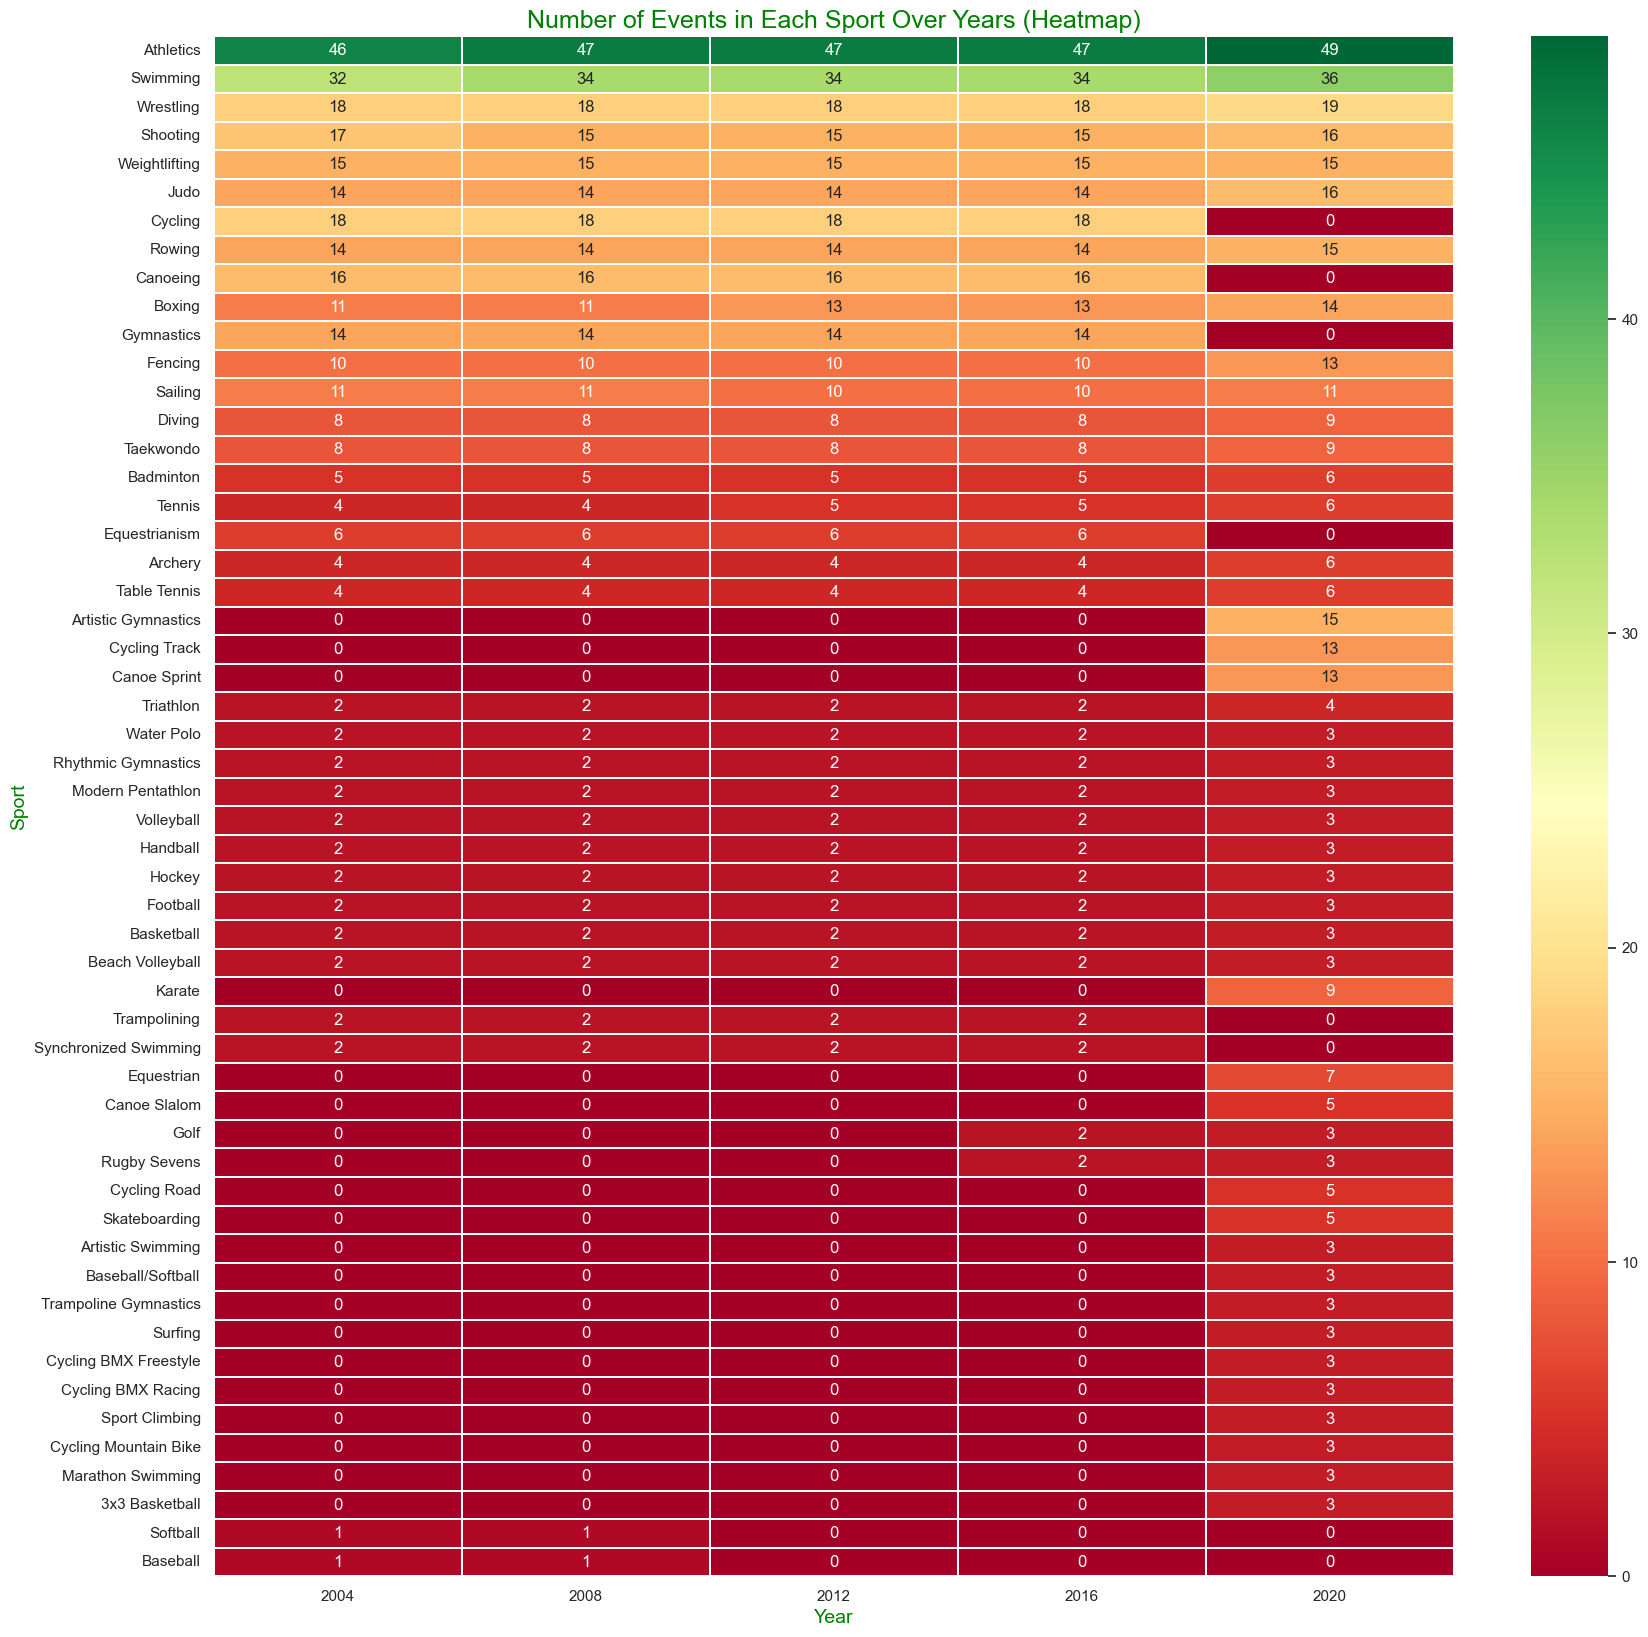

In [51] used -4.9 MiB RAM in 0.88s (system mean cpu 3%, single max cpu 100%), peaked 26.8 MiB above final usage, current RAM usage now 422.6 MiB


In [51]:
sport_year = df.pivot_table(index='Sport', columns='Year', values='Event', aggfunc=lambda x: len(x.unique()))
sport_year.fillna(0, inplace=True)
sport_year = sport_year.reindex(sport_year.sum(axis=1).sort_values(ascending=False).index)

# Affichage de la heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(sport_year, annot=True, linewidths=0.05, cmap="RdYlGn")
plt.xlabel('Year', size=14, color="green")
plt.ylabel('Sport', size=14, color="green")
plt.title('Number of Events in Each Sport Over Years (Heatmap)', size=18, color="green")
plt.show()


#### Count plot for medals in summer olympics

Text(0.5, 1.0, 'Count plot for medals in summer olympics')

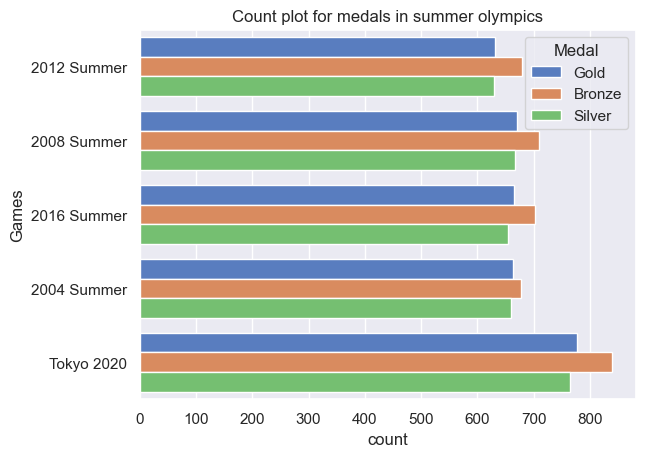

In [52] used 1.2 MiB RAM in 0.34s (system mean cpu 2%, single max cpu 100%), peaked 2.3 MiB above final usage, current RAM usage now 423.8 MiB


In [52]:
#Most Medals in Summer Olympics
data = df.groupby(['Event','Games'])['Medal'].value_counts()
sns.set(color_codes=True)                                               
sns.set_palette(sns.color_palette("muted"))
sns.countplot(y='Games', hue='Medal', data=df).set_title('Count plot for medals in summer olympics')

<Axes: xlabel='Games', ylabel='count'>

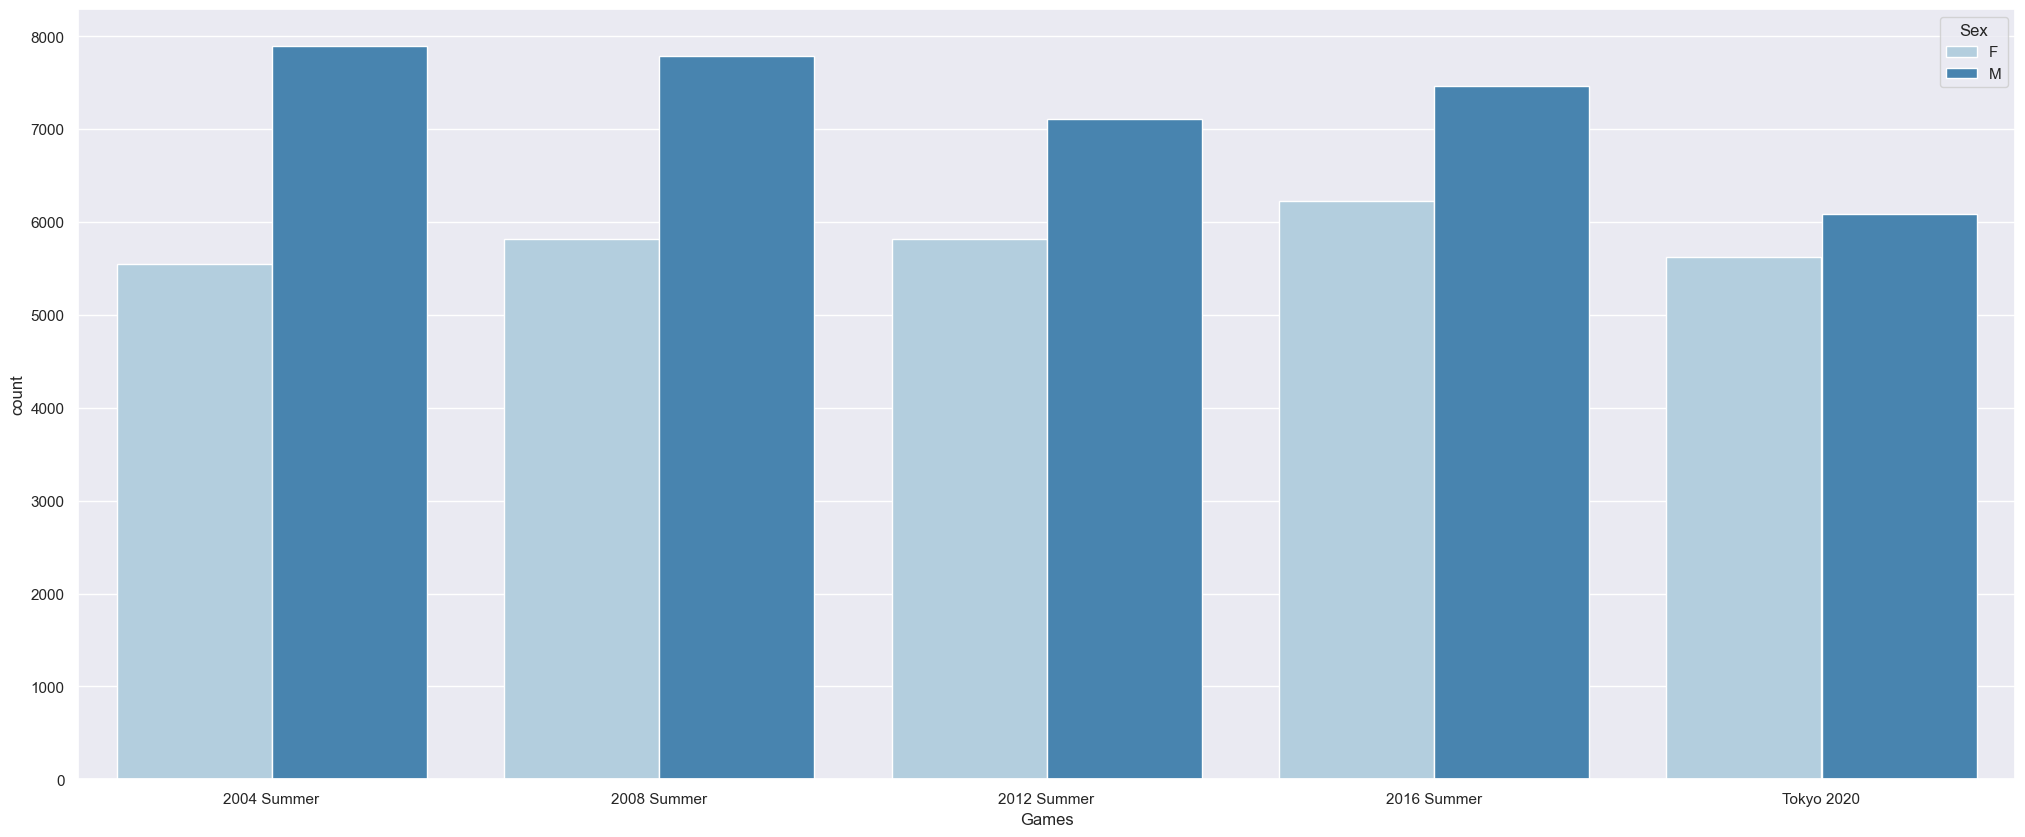

In [53] used 6.5 MiB RAM in 0.31s (system mean cpu 3%, single max cpu 100%), peaked 16.0 MiB above final usage, current RAM usage now 430.3 MiB


In [53]:
df_sports = df.groupby(["Games","Sex"])["Sport"].count().reset_index().rename(columns={"Sport":"count"})
plt.figure(figsize=(25,10))
sns.barplot(x="Games", y = "count", hue = "Sex", data = df_sports, palette = "Blues" )

In [54]:
# # RUSSIA
# df.loc[(df['Team'] == 'Soviet Union') & (df['NOC'] == 'URS'), ['Team', 'NOC']] = ['Russia', 'RUS'] # URSS période 1952-1988
df.loc[(df['Team'] == 'ROC') & (df['NOC'] == 'ROC'), ['Team', 'NOC']] = ['Germany', 'RUS'] # JO 2020

# # GERMANY
# df.loc[(df['Team'] == 'East Germany') & (df['NOC'] == 'GDR'), ['Team', 'NOC']] = ['Germany', 'GER']

# CHINA
df.loc[df['Team'] == "People's Republic of China", ['Team', 'NOC']] = ['China', 'CHN']

# UNITED STATES
df.loc[df['Team'] == "United States of America", ['Team', 'NOC']] = ['United States', 'USA']

In [54] used 0.0 MiB RAM in 0.12s (system mean cpu 2%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 430.3 MiB


#### Distribution of Age of Gold Medalists

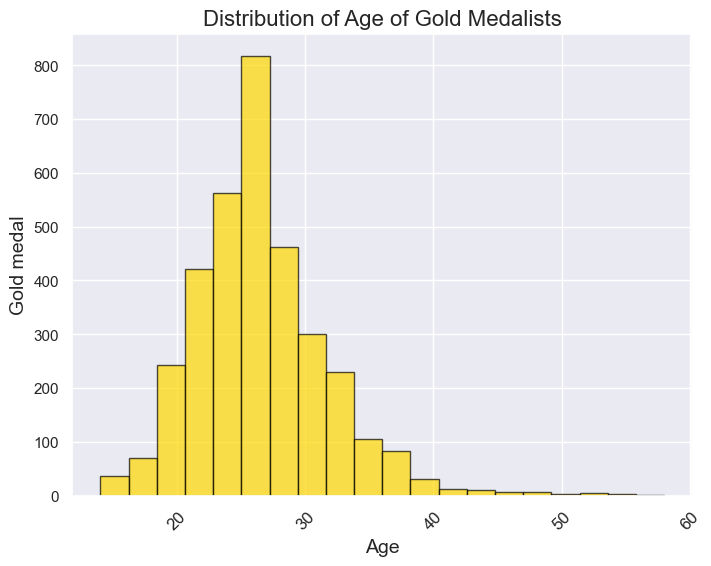

In [55] used 1.7 MiB RAM in 0.25s (system mean cpu 1%, single max cpu 100%), peaked 3.4 MiB above final usage, current RAM usage now 432.1 MiB


In [55]:
gold_medals = df[df['Medal'] == 'Gold']

plt.figure(figsize=(8, 6))  
plt.hist(gold_medals['Age'], bins=20, color='gold', edgecolor='black', alpha=0.7)  

plt.title('Distribution of Age of Gold Medalists', fontsize=16)  
plt.xlabel('Age', fontsize=14)  
plt.ylabel('Gold medal', fontsize=14)  
plt.xticks(rotation=45, fontsize=12)  


plt.show()
#


#### Evolution du nombres de médailles gagnés par les favoris

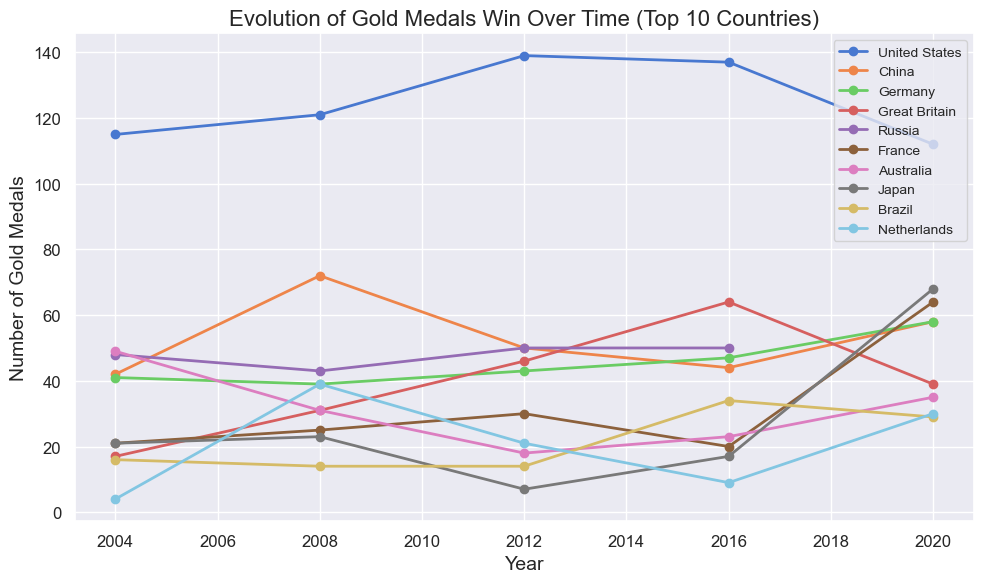

In [56] used 0.7 MiB RAM in 0.37s (system mean cpu 3%, single max cpu 100%), peaked 4.5 MiB above final usage, current RAM usage now 432.7 MiB


In [56]:
import matplotlib.pyplot as plt

# Filter the data to include only gold medal winners
gold_medals = df[df['Medal'] == 'Gold']

# Group the data by year and count the number of gold medals won each year for each country
gold_medals_by_year_and_country = gold_medals.groupby(['Year', 'Team'])['Medal'].count().unstack()

# Select the top 10 countries with the most gold medals overall
top_10_countries = gold_medals.groupby('Team')['Medal'].count().nlargest(10).index

# Plotting the curve for the evolution of gold medals over time for the top 10 countries
plt.figure(figsize=(10, 6))  # Taille de la figure

for country in top_10_countries:
    plt.plot(gold_medals_by_year_and_country.index, gold_medals_by_year_and_country[country], 
             marker='o', markersize=6, linewidth=2, label=country)  # Courbe pour chaque pays avec la légende

plt.title('Evolution of Gold Medals Win Over Time (Top 10 Countries)', fontsize=16)  # Titre
plt.xlabel('Year', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Number of Gold Medals', fontsize=14)  # Étiquette de l'axe y
plt.xticks(fontsize=12)  # Taille de la police des étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

plt.grid(True)  # Afficher la grille
plt.legend(fontsize=10)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


#### Evolution of Gold Medals per Athlete Over Time

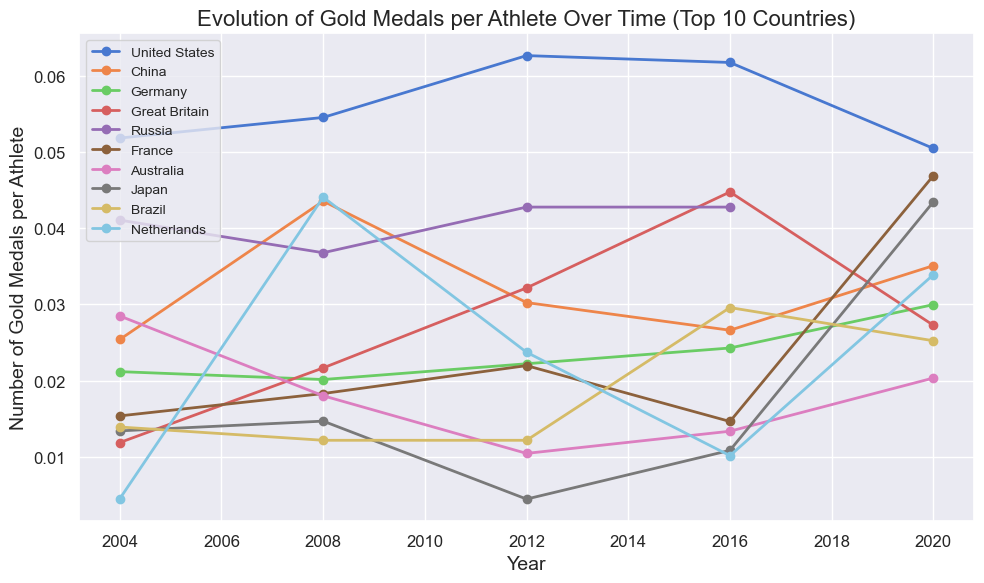

In [57] used 2.4 MiB RAM in 0.40s (system mean cpu 3%, single max cpu 100%), peaked 4.5 MiB above final usage, current RAM usage now 435.1 MiB


In [57]:
import matplotlib.pyplot as plt

# Calculate the total number of athletes per country
total_athletes_per_country = df.groupby('Team')['Name'].nunique()

# Filter the data to include only gold medal winners
gold_medals = df[df['Medal'] == 'Gold']

# Group the data by year and count the number of gold medals won each year for each country
gold_medals_by_year_and_country = gold_medals.groupby(['Year', 'Team'])['Medal'].count().unstack()

# Calculate the number of gold medals per athlete for each country and each year
gold_medals_per_athlete = gold_medals_by_year_and_country.div(total_athletes_per_country, axis=1)

# Select the top 10 countries with the most gold medals overall
top_10_countries = gold_medals.groupby('Team')['Medal'].count().nlargest(10).index

# Plotting the curve for the evolution of gold medals per athlete over time for the top 10 countries
plt.figure(figsize=(10, 6))  # Taille de la figure

for country in top_10_countries:
    plt.plot(gold_medals_per_athlete.index, gold_medals_per_athlete[country], 
             marker='o', markersize=6, linewidth=2, label=country)  # Courbe pour chaque pays avec la légende

plt.title('Evolution of Gold Medals per Athlete Over Time (Top 10 Countries)', fontsize=16)  # Titre
plt.xlabel('Year', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Number of Gold Medals per Athlete', fontsize=14)  # Étiquette de l'axe y
plt.xticks(fontsize=12)  # Taille de la police des étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

plt.grid(True)  # Afficher la grille
plt.legend(fontsize=10)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


#### Total Number of Medals Won by Country and Medal Type

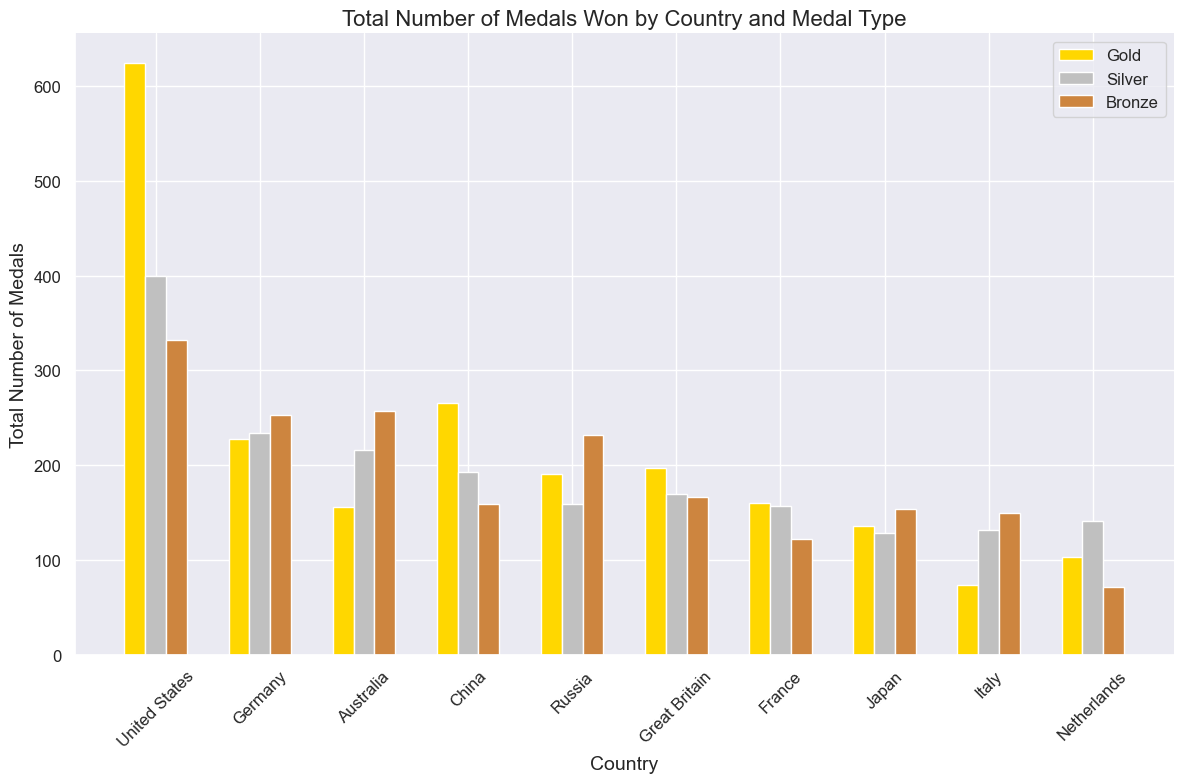

In [58] used 1.4 MiB RAM in 0.32s (system mean cpu 3%, single max cpu 100%), peaked 7.2 MiB above final usage, current RAM usage now 436.5 MiB


In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Group the data by country and count the total number of medals won by each country and each type of medal
medals_by_country = df.groupby(['Team', 'Medal']).size().unstack(fill_value=0)

# Select the top 10 countries with the most total medals
top_10_countries = medals_by_country.sum(axis=1).nlargest(10).index

# Select the medal types
medal_types = ['Gold', 'Silver', 'Bronze']

# Set the position of each bar on the x-axis
x = np.arange(len(top_10_countries))

# Set the width of the bars
width = 0.2

# Assign colors to each medal type
colors = {'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'peru'}

# Plotting the grouped bar graph
plt.figure(figsize=(12, 8))  # Taille de la figure

for i, medal in enumerate(medal_types):
    plt.bar(x - width + i * width, medals_by_country.loc[top_10_countries, medal], 
            width=width, label=medal, color=colors[medal])

plt.title('Total Number of Medals Won by Country and Medal Type', fontsize=16)  # Titre
plt.xlabel('Country', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Total Number of Medals', fontsize=14)  # Étiquette de l'axe y
plt.xticks(ticks=x, labels=top_10_countries, rotation=45, fontsize=12)  # Étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

# Supprimer les bordures de la figure
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(fontsize=12)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


#### Strongest Evolution in Medals Won by Team

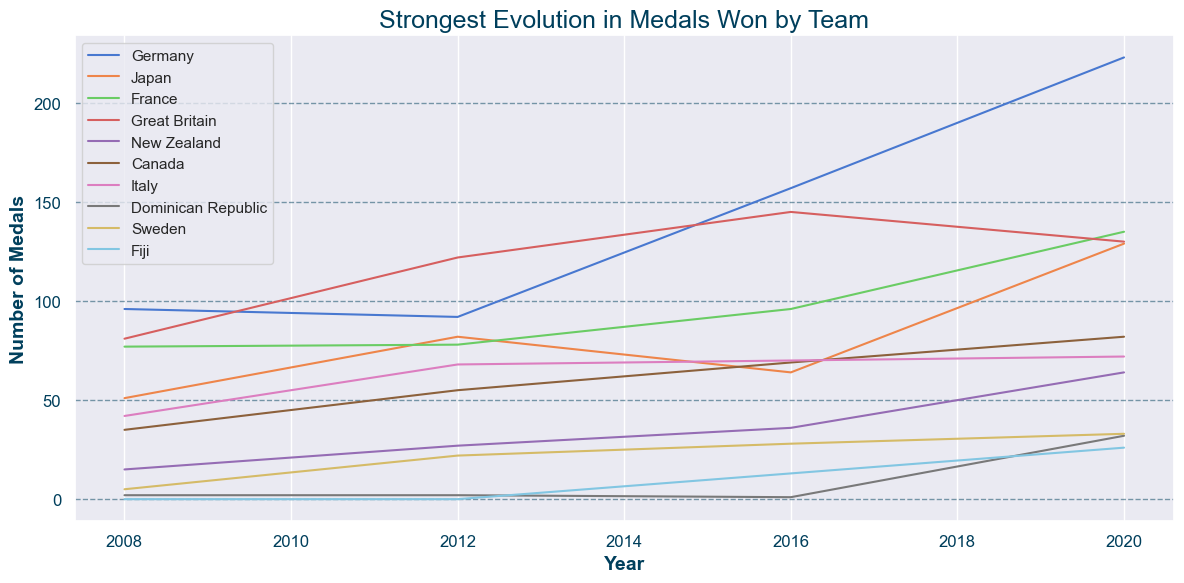

In [59] used 2.8 MiB RAM in 0.35s (system mean cpu 2%, single max cpu 100%), peaked 5.4 MiB above final usage, current RAM usage now 439.4 MiB


In [59]:
# Filter the data to include only Summer Olympic Games between 2010 and 2020
summer_games = df[(df['Season'] == 'Summer') & (df['Year'] >= 2008) & (df['Year'] <= 2020)]

# Group the data by team and year, and calculate the total number of medals won by each team in each year
medals_by_year = summer_games.groupby(['Team', 'Year'])['Medal'].count().unstack()

# Calculate the difference in the number of medals won by each team between the first year and the last year
medal_difference = medals_by_year.iloc[:, -1] - medals_by_year.iloc[:, 0]

# Sort the teams based on the difference in the number of medals won in descending order
sorted_teams = medal_difference.sort_values(ascending=False)

# Select the top 5 teams with the largest increase in medals won
top_5_teams = sorted_teams.index[:10]

# Create a line chart showing the number of medals won by the top 5 teams in each year
plt.figure(figsize=(12, 6))
for team in top_5_teams:
    plt.plot(medals_by_year.loc[team], label=team)
plt.title('Strongest Evolution in Medals Won by Team', fontsize=18, color='#003f5c')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.legend()
plt.tight_layout()
plt.show()


#### Number of Sports Over Time

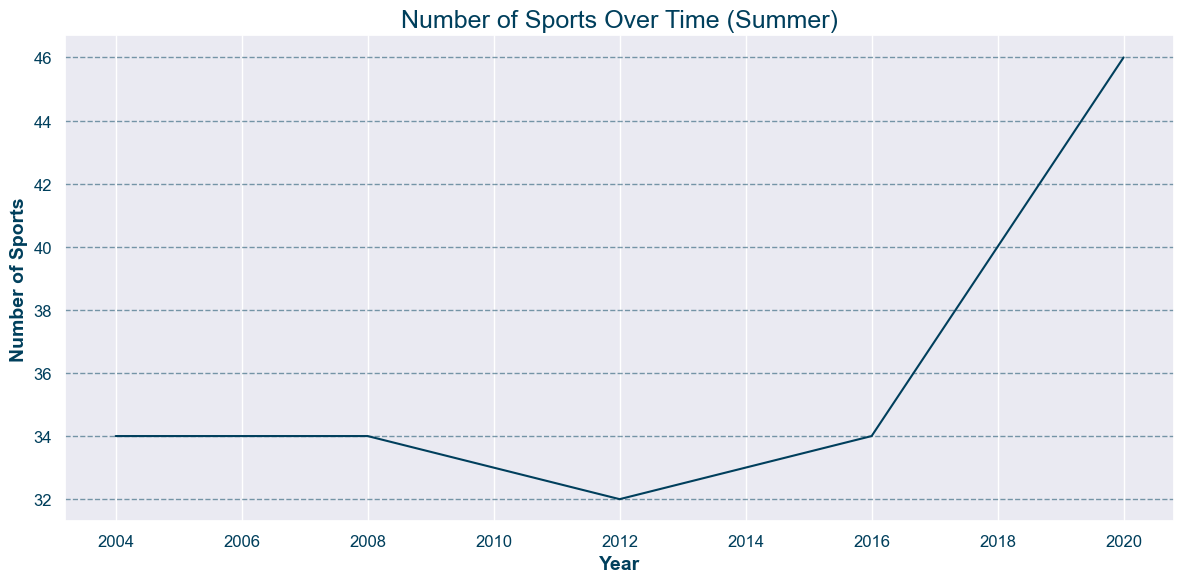

In [60] used 3.3 MiB RAM in 0.32s (system mean cpu 4%, single max cpu 100%), peaked 5.4 MiB above final usage, current RAM usage now 442.7 MiB


In [60]:
summer_sports_per_year = df[df['Season'] == 'Summer'].groupby('Year')['Sport'].nunique()

plt.figure(figsize=(12, 6))
plt.plot(summer_sports_per_year.index, summer_sports_per_year.values, color='#003f5c')
plt.title('Number of Sports Over Time (Summer)', fontsize=18, color='#003f5c')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Sports', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.tight_layout()
plt.show()

#### Last sport that apperead with most medals

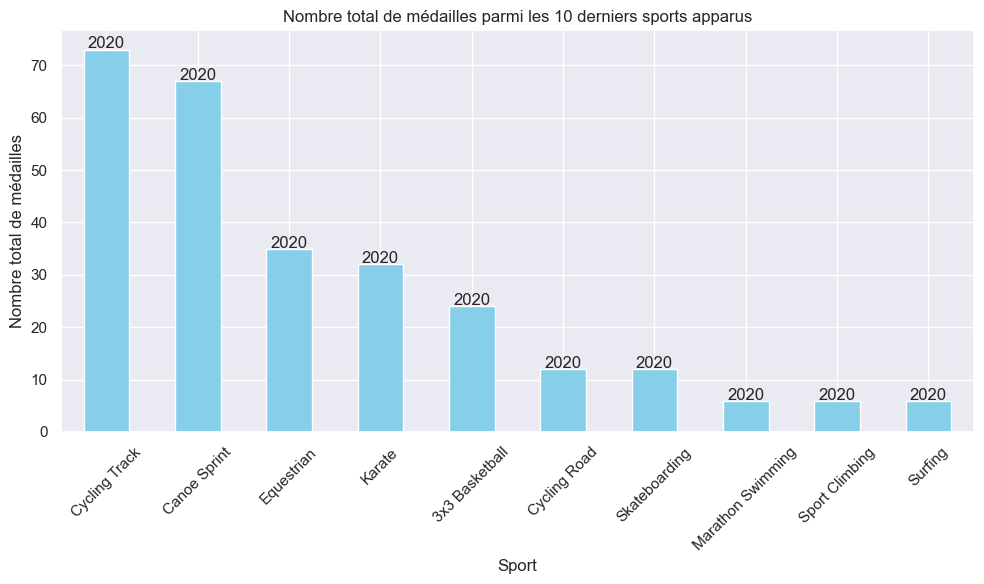

In [61] used -0.4 MiB RAM in 0.30s (system mean cpu 3%, single max cpu 100%), peaked 4.5 MiB above final usage, current RAM usage now 442.3 MiB


In [61]:
# Identifier les années où chaque sport est apparu pour la première fois
first_appearance = summer_games.groupby('Sport')['Year'].min()

# Sélectionner les 10 derniers sports apparus
latest_sports = first_appearance.sort_values(ascending=False).head(10)

# Filtrer les données pour inclure seulement les médailles des 10 derniers sports
latest_sports_medals = summer_games[summer_games['Sport'].isin(latest_sports.index)]

# Compter le nombre total de médailles par sport
medal_counts = latest_sports_medals.groupby('Sport')['Medal'].count().sort_values(ascending=False)

# Créer un graphique à barres
plt.figure(figsize=(10, 6))
bar_plot = medal_counts.plot(kind='bar', color='skyblue')

# Ajouter l'année d'apparition à chaque barre
for i, v in enumerate(medal_counts):
    sport_name = medal_counts.index[i]
    year = first_appearance[sport_name]
    bar_plot.text(i, v + 0.2, str(year), ha='center')

plt.title('Nombre total de médailles parmi les 10 derniers sports apparus')
plt.xlabel('Sport')
plt.ylabel('Nombre total de médailles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Sports with the Most Medals

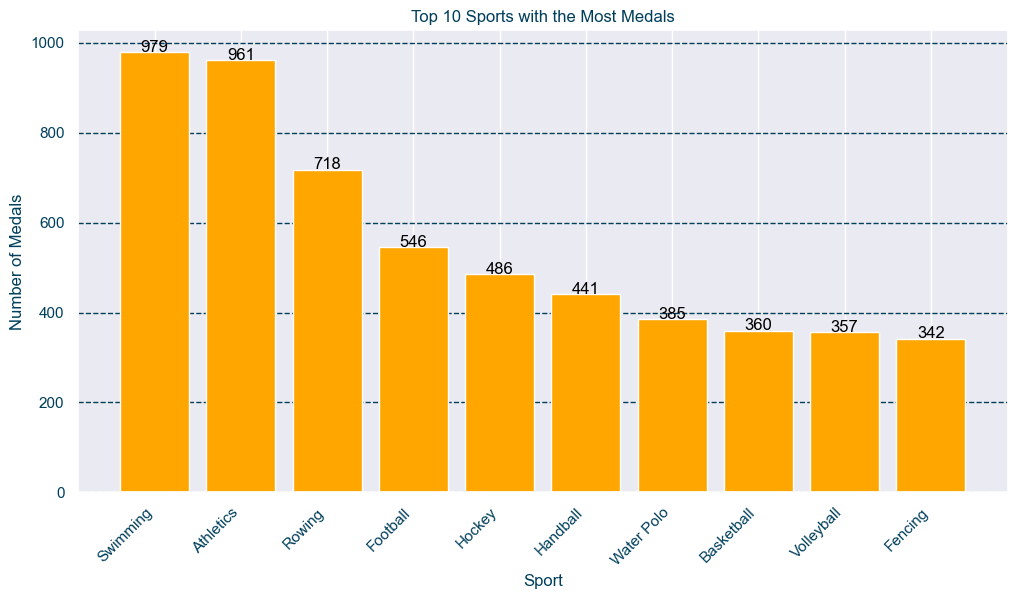

In [62] used 2.5 MiB RAM in 0.27s (system mean cpu 2%, single max cpu 100%), peaked 5.1 MiB above final usage, current RAM usage now 444.8 MiB


In [62]:
top_10_sports = df.groupby('Sport')['Medal'].count().nlargest(10)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_10_sports.index, top_10_sports.values, color='#ffa600')
ax.set_title('Top 10 Sports with the Most Medals', color='#003f5c')
ax.set_xlabel('Sport', color='#003f5c')
ax.set_ylabel('Number of Medals', color='#003f5c')
ax.tick_params(axis='both', colors='#003f5c')
ax.grid(axis='y', linestyle='--', color='#003f5c')

for i, sport in enumerate(top_10_sports.index):
    ax.text(i, top_10_sports[sport] + 0.5, str(top_10_sports[sport]), color='black', ha='center')

plt.xticks(rotation=45, ha='right')
plt.show()


In [63]:
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_athletes['Athlete'] + ' - ' + top_10_athletes['Sport'], 
                top_10_athletes['Medal Count'], color='gold', edgecolor='black', alpha=0.7)

# Add the number of medals in the middle of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', 
             va='center', ha='left', fontsize=10)

plt.xlabel('Medal Count', fontsize=14)
plt.ylabel('Athlete - Discipline', fontsize=14)  # Updated ylabel
plt.title('Top 10 Athletes with Most Medals', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the athlete with most medals on top
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add grid lines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


NameError: name 'top_10_athletes' is not defined

<Figure size 1000x600 with 0 Axes>

In [63] used 2.3 MiB RAM in 0.12s (system mean cpu 2%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 447.1 MiB


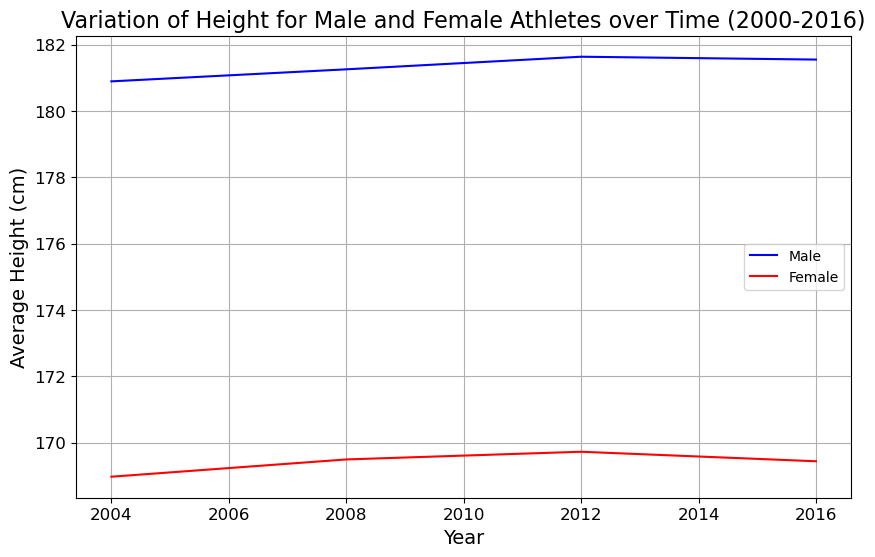

In [78] used 5.3 MiB RAM in 0.33s (system mean cpu 7%, single max cpu 71%), peaked 2.3 MiB above final usage, current RAM usage now 528.6 MiB


In [ ]:

# Filter the data to include only male and female athletes between 2000 and 2016
athletes_2000_2016 = df[(df['Year'] >= 2000) & (df['Year'] <= 2016)]

# Group the data by gender and year, and calculate the average height for each gender and year
average_height_by_gender_and_year_2000_2016 = athletes_2000_2016.groupby(['Sex', 'Year'])['Height'].mean()

# Create a line plot to visualize the variation of height over time between 2000 and 2016 for both male and female athletes
plt.figure(figsize=(10, 6))

# Plot the average height for male athletes
male_heights = average_height_by_gender_and_year_2000_2016['M']
plt.plot(male_heights.index, male_heights.values, color='blue', label='Male')

# Plot the average height for female athletes
female_heights = average_height_by_gender_and_year_2000_2016['F']
plt.plot(female_heights.index, female_heights.values, color='red', label='Female')

plt.title('Variation of Height for Male and Female Athletes over Time (2000-2016)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Height (cm)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend()
plt.show()



# TEST PERSO (REVISIONS)

## Fusion des bases + Nettoyage

In [276]:
df = pd.read_csv("data/athlete_events.csv")
df = df[(df['Year'] > 2000) & (df['Year'] <= 2016) & (df['Season'] == 'Summer')]

region_df = pd.read_csv("data/noc_regions.csv")
dictionary = pd.read_csv("data/dictionary.csv")

In [276] used 7.4 MiB RAM in 0.53s (system mean cpu 42%, single max cpu 100%), peaked 44.2 MiB above final usage, current RAM usage now 1973.6 MiB


In [277]:
df.shape

(53653, 14)

In [277] used 0.0 MiB RAM in 0.10s (system mean cpu 25%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1973.6 MiB


In [278]:
# Fusion de la colonne 'Team' du DataFrame df avec la colonne 'Country' du DataFrame dictionary_df
merged_df = pd.merge(df, dictionary, left_on='Team', right_on='Country', how='left') # how = 'left' pour conserver toutes les lignes de df

# Fusion du DataFrame merged_df avec le DataFrame region_df en se basant sur la colonne 'NOC' dans merged_df et dans region_df
final_merged_df = pd.merge(merged_df, region_df, on='NOC', how='left')

# Affectation du résultat final à la variable df
df = final_merged_df
df.head()

df



,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Code,Population,GDP per Capita,region,notes
0,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,CHN,1.371220e+09,8027.683810,China,NaN
1,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,Norway,NOR,5.195921e+06,74400.369777,Norway,NaN
2,Andreea Aanei,F,22.0,170.0,125.0,Romania,ROU,2016 Summer,2016,Summer,Rio de Janeiro,Weightlifting,Weightlifting Women's Super-Heavyweight,NaN,Romania,ROM,1.983239e+07,8972.922518,Romania,NaN
3,Fritz Aanes,M,26.0,187.0,89.0,Norway,NOR,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Light-Heavyweight, Greco-Roman",NaN,Norway,NOR,5.195921e+06,74400.369777,Norway,NaN
4,Jamale (Djamel-) Aarrass (Ahrass-),M,30.0,187.0,76.0,France,FRA,2012 Summer,2012,Summer,London,Athletics,"Athletics Men's 1,500 metres",NaN,France,FRA,6.680838e+07,36205.568102,France,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53648,Stavroula Zygouri,F,36.0,171.0,63.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Women's Middleweight, Freestyle",NaN,Greece,GRE,1.082373e+07,18002.230578,Greece,NaN
53649,Olesya Nikolayevna Zykina,F,23.0,171.0,64.0,Russia,RUS,2004 Summer,2004,Summer,Athina,Athletics,Athletics Women's 4 x 400 metres Relay,Silver,Russia,RUS,1.440968e+08,9092.580536,Russia,NaN
53650,Fernando scar Zylberberg,M,27.0,168.0,76.0,Argentina,ARG,2004 Summer,2004,Summer,Athina,Hockey,Hockey Men's Hockey,NaN,Argentina,ARG,4.341676e+07,13431.878340,Argentina,NaN
53651,Aleksandr Viktorovich Zyuzin,M,28.0,183.0,72.0,Russia,RUS,2004 Summer,2004,Summer,Athina,Rowing,Rowing Men's Lightweight Coxless Fours,NaN,Russia,RUS,1.440968e+08,9092.580536,Russia,NaN


In [278] used 4.0 MiB RAM in 0.15s (system mean cpu 32%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1977.6 MiB


In [279]:
df.shape

(53653, 20)

In [279] used 0.0 MiB RAM in 0.10s (system mean cpu 29%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1977.6 MiB


## 3.2. Nettoyer les données

### 3.2.1. Données manquantes

In [280]:
df.drop(columns=['Country', 'Code', 'region', 'notes'], inplace=True)

In [280] used 0.0 MiB RAM in 0.11s (system mean cpu 24%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1977.6 MiB


In [281]:
# Vérification des valeurs NULL 
df.isnull().sum() 

Name                  0
Sex                   0
Age                   2
Height              531
Weight              779
Team                  0
NOC                   0
Games                 0
Year                  0
Season                0
City                  0
Sport                 0
Event                 0
Medal             45640
Population         5366
GDP per Capita     6753
dtype: int64

In [281] used 0.4 MiB RAM in 0.12s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1978.0 MiB


#### Traitement des valeurs nulles


In [282]:
df[df['Name'] == 'Ragnhild Margrethe Aamodt']

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Population,GDP per Capita
1,Ragnhild Margrethe Aamodt,F,27.0,163.0,NaN,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,5195921.0,74400.369777


In [282] used 0.0 MiB RAM in 0.11s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1978.0 MiB


In [283]:
# Calculer les moyennes de la taille et du poids par sexe
average_height = df.groupby('Sex')['Height'].mean()
average_weight = df.groupby('Sex')['Weight'].mean()

# Créer un DataFrame à partir des moyennes calculées
average_stats_df = pd.DataFrame({'Average Height': average_height, 'Average Weight': average_weight})
average_stats_df


,Average Height,Average Weight
Sex,,
F,169.419330,61.723618
M,181.319522,78.623565


In [283] used 0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1978.0 MiB


In [284]:
from sklearn.impute import SimpleImputer

df_male = df[df['Sex'] == 'M']
df_female = df[df['Sex'] == 'F']
columns_to_impute = ['Age', 'Height', 'Weight']

# Créer un imputer avec la stratégie 'mean' pour remplacer les valeurs nulles par la moyenne
imputer = SimpleImputer(strategy='mean')

df_male[columns_to_impute] = imputer.fit_transform(df_male[columns_to_impute])
df_female[columns_to_impute] = imputer.fit_transform(df_female[columns_to_impute])

df = pd.concat([df_male, df_female])


In [284] used 4.6 MiB RAM in 0.13s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1982.6 MiB


C:\Users\guill\AppData\Local\Temp\ipykernel_828\2281189847.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male[columns_to_impute] = imputer.fit_transform(df_male[columns_to_impute])
C:\Users\guill\AppData\Local\Temp\ipykernel_828\2281189847.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_female[columns_to_impute] = imputer.fit_transform(df_female[columns_to_impute])


In [285]:
df[df['Name'] == 'Ragnhild Margrethe Aamodt']

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Population,GDP per Capita
1,Ragnhild Margrethe Aamodt,F,27.0,163.0,61.723618,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,5195921.0,74400.369777


In [285] used 0.0 MiB RAM in 0.11s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1982.6 MiB


In [286]:
df.isnull().sum()

Name                  0
Sex                   0
Age                   0
Height                0
Weight                0
Team                  0
NOC                   0
Games                 0
Year                  0
Season                0
City                  0
Sport                 0
Event                 0
Medal             45640
Population         5366
GDP per Capita     6753
dtype: int64

In [286] used 0.0 MiB RAM in 0.12s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1982.6 MiB


In [287]:
# Définir la fonction de mapping
def map_medal(medal):
    if medal == 'Gold':
        return 3
    elif medal == 'Silver':
        return 2
    elif medal == 'Bronze':
        return 1
    else:
        return 0

# Appliquer la fonction de mapping à la colonne 'Medal'
df['Medal'] = df['Medal'].map(map_medal)
df


,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Population,GDP per Capita
0,A Lamusi,M,23.0,170.000000,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0,1.371220e+09,8027.683810
3,Fritz Aanes,M,26.0,187.000000,89.0,Norway,NOR,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Light-Heavyweight, Greco-Roman",0,5.195921e+06,74400.369777
4,Jamale (Djamel-) Aarrass (Ahrass-),M,30.0,187.000000,76.0,France,FRA,2012 Summer,2012,Summer,London,Athletics,"Athletics Men's 1,500 metres",0,6.680838e+07,36205.568102
5,Abdelhak Aatakni,M,24.0,181.319522,64.0,Morocco,MAR,2012 Summer,2012,Summer,London,Boxing,Boxing Men's Light-Welterweight,0,3.437751e+07,2878.201342
8,Nstor Abad Sanjun,M,23.0,167.000000,64.0,Spain,ESP,2016 Summer,2016,Summer,Rio de Janeiro,Gymnastics,Gymnastics Men's Individual All-Around,0,4.641827e+07,25831.582305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53643,Viktoriya Viktorovna Zyabkina,F,23.0,174.000000,62.0,Kazakhstan,KAZ,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Women's 200 metres,0,1.754413e+07,10509.981070
53644,Viktoriya Viktorovna Zyabkina,F,23.0,174.000000,62.0,Kazakhstan,KAZ,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Women's 4 x 100 metres Relay,0,1.754413e+07,10509.981070
53648,Stavroula Zygouri,F,36.0,171.000000,63.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Women's Middleweight, Freestyle",0,1.082373e+07,18002.230578
53649,Olesya Nikolayevna Zykina,F,23.0,171.000000,64.0,Russia,RUS,2004 Summer,2004,Summer,Athina,Athletics,Athletics Women's 4 x 400 metres Relay,2,1.440968e+08,9092.580536


In [287] used 1.2 MiB RAM in 0.13s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1983.9 MiB


### 3.2.2. Valeurs atypiques (outliers)

Tracer, en un graphique, le boxplot des variables numériques : 

<Axes: >

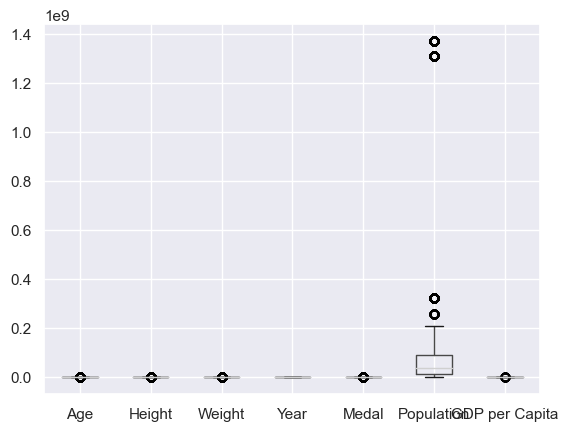

In [288] used 5.3 MiB RAM in 0.44s (system mean cpu 13%, single max cpu 100%), peaked 2.3 MiB above final usage, current RAM usage now 1989.2 MiB


In [288]:
df.boxplot()

<Axes: >

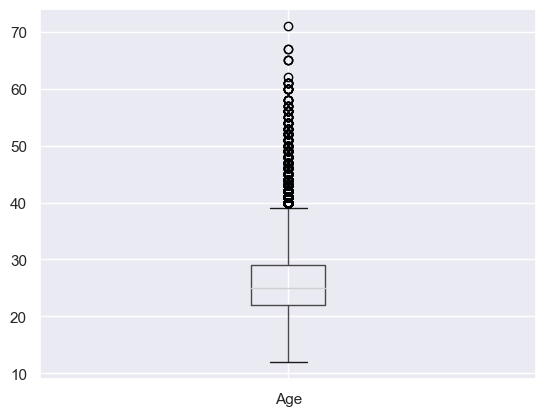

In [289] used 0.1 MiB RAM in 0.22s (system mean cpu 7%, single max cpu 100%), peaked 1.1 MiB above final usage, current RAM usage now 1989.3 MiB


In [289]:
#Tracer le boxplot de la variable Age : 
df.boxplot(column='Age',return_type='axes')

In [290]:
# On va modifier les plus hauts outliers identifiés pour Age par la valeur du 99ème quantile

cols = ['Age']
low = .05
high = .99 #Return values at the given quantile  0.99 (99% quantile)
quant_df =  df[cols].quantile([low, high])
print(quant_df)



       Age
0.05  18.0
0.99  44.0
In [290] used 0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1989.4 MiB


In [291]:
higher = quant_df.loc[high,'Age']
higher

def func(x):
    if x >= higher:
        return higher
    else:
        return x

df['Age'] = df['Age'].apply(func)

In [291] used 1.2 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1990.6 MiB


In [292]:
#vérifier que pour les valeurs les plus hautes, on a bien modifié la valeur de fare par : 43 ans	

df[df['Age'].ge(quant_df.loc[high,'Age'])]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Population,GDP per Capita
748,Teruyoshi Akiyama,M,44.0,168.0,65.0,Japan,JPN,2016 Summer,2016,Summer,Rio de Janeiro,Shooting,"Shooting Men's Rapid-Fire Pistol, 25 metres",0,126958472.0,32477.215145
802,Nasser Salih Nasser Abdullah Al-Attiya,M,44.0,178.0,82.0,Qatar,QAT,2016 Summer,2016,Summer,Rio de Janeiro,Shooting,Shooting Men's Skeet,0,2235355.0,73653.394435
821,Dadallah Noor Mohamed Al-Bulushi,M,44.0,172.0,86.0,Oman,OMA,2008 Summer,2008,Summer,Beijing,Shooting,"Shooting Men's Small-Bore Rifle, Prone, 50 metres",0,4490541.0,15550.676251
828,Fehaid Al-Deehani,M,44.0,178.0,95.0,Kuwait,KUW,2012 Summer,2012,Summer,London,Shooting,Shooting Men's Trap,1,3892115.0,29300.575575
829,Fehaid Al-Deehani,M,44.0,178.0,95.0,Kuwait,KUW,2012 Summer,2012,Summer,London,Shooting,Shooting Men's Double Trap,0,3892115.0,29300.575575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51017,Tinne Eva Caroline Wilhelmsson-Silfvn,F,44.0,167.0,60.0,Sweden,SWE,2016 Summer,2016,Summer,Rio de Janeiro,Equestrianism,"Equestrianism Mixed Dressage, Team",0,9798871.0,50579.673649
51472,Annette Mary Woodward,F,44.0,166.0,66.0,Australia,AUS,2004 Summer,2004,Summer,Athina,Shooting,"Shooting Women's Sporting Pistol, 25 metres",0,23781169.0,56310.962993
51807,Mieko Yagi,F,44.0,160.0,53.0,Japan,JPN,2008 Summer,2008,Summer,Beijing,Equestrianism,"Equestrianism Mixed Dressage, Individual",0,126958472.0,32477.215145
51808,Mieko Yagi,F,44.0,160.0,53.0,Dow Jones,JPN,2008 Summer,2008,Summer,Beijing,Equestrianism,"Equestrianism Mixed Dressage, Team",0,NaN,NaN


In [292] used -0.0 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1990.6 MiB


<Axes: >

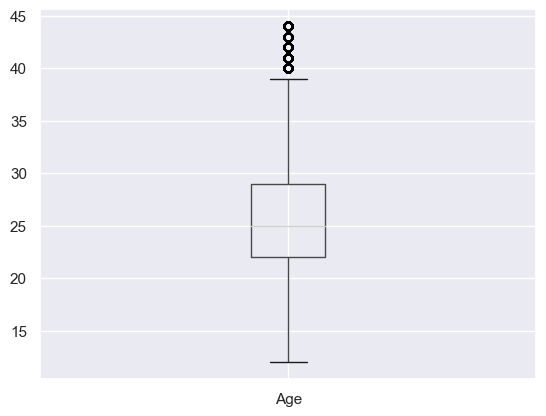

In [293] used 0.9 MiB RAM in 0.21s (system mean cpu 10%, single max cpu 100%), peaked 0.6 MiB above final usage, current RAM usage now 1991.5 MiB


In [293]:
df.boxplot(column='Age',return_type='axes')

In [294]:
df.isnull().sum()

Name                 0
Sex                  0
Age                  0
Height               0
Weight               0
Team                 0
NOC                  0
Games                0
Year                 0
Season               0
City                 0
Sport                0
Event                0
Medal                0
Population        5366
GDP per Capita    6753
dtype: int64

In [294] used 0.3 MiB RAM in 0.12s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1991.8 MiB


### 3.3.1 Indépendance des attributs numériques


In [295]:
# # effectuer l'encodage du feature Medal (ajouter de colonnes au dataframe) : 

# encoder=preprocessing.OneHotEncoder(sparse_output=False)
# encoder.fit(df[['Medal']])
# columns_name = encoder.get_feature_names_out(['Medal'])
# df_encoded = pd.DataFrame(encoder.transform(df[['Medal']]))
# df_encoded.columns = columns_name
# df= pd.concat([df, df_encoded], axis=1)

In [295] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1991.8 MiB


In [296]:
# effectuer l'encodage du feature Sex (ajouter de colonnes au dataframe) : 

# Effectuer l'encodage pour la variable 'Sex'
df_encoded = pd.get_dummies(df['Sex'], prefix='Sex')

# Concaténer le dataframe original avec le nouveau dataframe encodé
df = pd.concat([df, df_encoded], axis=1)

# Supprimer la colonne 'Sex' d'origine
df.drop('Sex', axis=1, inplace=True)
df



,Name,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Population,GDP per Capita,Sex_F,Sex_M
0,A Lamusi,23.0,170.000000,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0,1.371220e+09,8027.683810,False,True
3,Fritz Aanes,26.0,187.000000,89.0,Norway,NOR,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Light-Heavyweight, Greco-Roman",0,5.195921e+06,74400.369777,False,True
4,Jamale (Djamel-) Aarrass (Ahrass-),30.0,187.000000,76.0,France,FRA,2012 Summer,2012,Summer,London,Athletics,"Athletics Men's 1,500 metres",0,6.680838e+07,36205.568102,False,True
5,Abdelhak Aatakni,24.0,181.319522,64.0,Morocco,MAR,2012 Summer,2012,Summer,London,Boxing,Boxing Men's Light-Welterweight,0,3.437751e+07,2878.201342,False,True
8,Nstor Abad Sanjun,23.0,167.000000,64.0,Spain,ESP,2016 Summer,2016,Summer,Rio de Janeiro,Gymnastics,Gymnastics Men's Individual All-Around,0,4.641827e+07,25831.582305,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53643,Viktoriya Viktorovna Zyabkina,23.0,174.000000,62.0,Kazakhstan,KAZ,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Women's 200 metres,0,1.754413e+07,10509.981070,True,False
53644,Viktoriya Viktorovna Zyabkina,23.0,174.000000,62.0,Kazakhstan,KAZ,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,Athletics Women's 4 x 100 metres Relay,0,1.754413e+07,10509.981070,True,False
53648,Stavroula Zygouri,36.0,171.000000,63.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Women's Middleweight, Freestyle",0,1.082373e+07,18002.230578,True,False
53649,Olesya Nikolayevna Zykina,23.0,171.000000,64.0,Russia,RUS,2004 Summer,2004,Summer,Athina,Athletics,Athletics Women's 4 x 400 metres Relay,2,1.440968e+08,9092.580536,True,False


In [296] used 6.8 MiB RAM in 0.12s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1998.6 MiB


In [297]:
pd.DataFrame(abs(df.corr(numeric_only=True)['Medal']).sort_values(ascending = False))


,Medal
Medal,1.000000
GDP per Capita,0.108664
Population,0.087022
Height,0.075376
Weight,0.068399
Sex_F,0.022426
Sex_M,0.022426
Age,0.019861
Year,0.001935


In [297] used -0.0 MiB RAM in 0.11s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1998.6 MiB


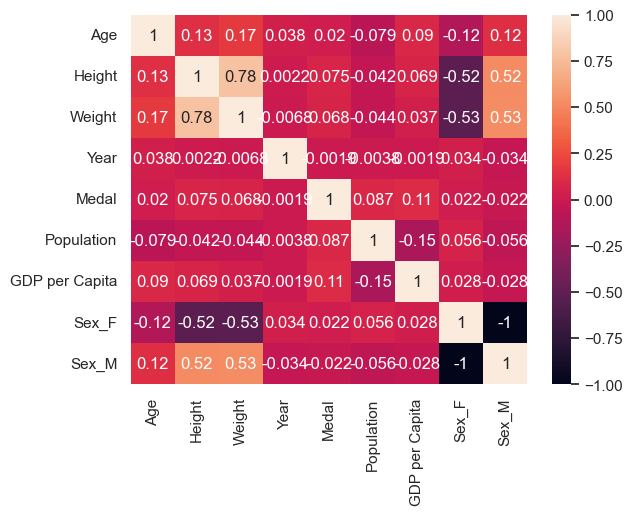

In [298] used 1.7 MiB RAM in 0.37s (system mean cpu 15%, single max cpu 100%), peaked 2.4 MiB above final usage, current RAM usage now 2000.3 MiB


In [298]:
#Les collonnes non numériques ne sont pas analysées
corrMatrix = df.corr(numeric_only=True)
sns.heatmap(corrMatrix, annot=True)
plt.show()

### 3.3.2 Indépendance des attributs catégoriels

Variables catégorielles non regardées encore : Team, Games, City



In [299]:
# entre Team et City

ct_cat = pd.crosstab(df.Games, df.City)
ct_cat
chi2, p_value, _, _ = sp.stats.chi2_contingency(ct_cat)
print(chi2, p_value)

160959.0 0.0
In [299] used 0.4 MiB RAM in 0.12s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2000.7 MiB


**Conclusion** : si p_value < 0.05 : Cabin et Embarked sont dépendants. 
**Il faudra supprimer un des deux par la suite.**

### 3.3.2. Feature engineering

#### Discrétisation des variables numériques continues

Nous allons discrétiser les 3 variables : 
* Age 
* Height 
* Weight 


https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial

In [300]:
df.isnull().sum()

Name                 0
Age                  0
Height               0
Weight               0
Team                 0
NOC                  0
Games                0
Year                 0
Season               0
City                 0
Sport                0
Event                0
Medal                0
Population        5366
GDP per Capita    6753
Sex_F                0
Sex_M                0
dtype: int64

In [300] used 0.0 MiB RAM in 0.11s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2000.7 MiB


In [301]:
# Discrétiser la variable 'Age' en 5 bins
# df['Age_Category'] = pd.cut(df['Age'], bins=5, labels=['Enfant', 'Adolescent', 'Jeune Adulte', 'Adulte', 'Personne âgée'])

# # Discrétiser la variable 'Height' en 5 bins
# df['Height_Category'] = pd.cut(df['Height'], bins=5, labels=['Très petit', 'Petit', 'Moyen', 'Grand', 'Très grand'])

# # Discrétiser la variable 'Weight' en 5 bins
# df['Weight_Category'] = pd.cut(df['Weight'], bins=5, labels=['Très léger', 'Léger', 'Moyen', 'Lourd', 'Très lourd'])

# Afficher les premières lignes du dataframe avec les nouvelles variables catégorielles


In [301] used 0.0 MiB RAM in 0.10s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2000.7 MiB


In [302]:
df.dtypes

Name               object
Age               float64
Height            float64
Weight            float64
Team               object
NOC                object
Games              object
Year                int64
Season             object
City               object
Sport              object
Event              object
Medal               int64
Population        float64
GDP per Capita    float64
Sex_F                bool
Sex_M                bool
dtype: object

In [302] used 0.0 MiB RAM in 0.10s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2000.7 MiB


#### Création de nouveaux features

Nous allons créer 3 features : 

1. Organisateur : Pays organisateur : Créer une variable binaire qui indique si le pays de l'athlète est le pays hôte des Jeux Olympiques correspondants. Cela pourrait avoir un impact sur les performances des athlètes en raison du soutien local et des conditions environnementales favorables.


In [303]:
# # Définir une fonction pour vérifier si la ville est le pays hôte
# def is_host_country(row):
#     if row['Team'] in row['Team']:
#         return 1
#     else:
#         return 0

# # Appliquer la fonction à chaque ligne du DataFrame
# df['Host_Country'] = df.apply(is_host_country, axis=1)
# df

In [303] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2000.7 MiB


### 3.3.3 Encodage des attributs discrets/catégoriels

Une étape à effectuer avant de pouvoir commencer notre modélisation est de convertir tous nos features catégoriels en nombres, car nos algorithmes ne peuvent prendre qu'un tableau de nombres en entrée, pas des noms ou des lettres. 
Choisissez les variables à tarnsformer, en utilisant des encoders adaptés. 

-----------------------------------------------------------------------------

LabelEncoder : Si vous avez des variables catégorielles ordinales avec un ordre spécifique, telles que 'Season' (saison des Jeux Olympiques), vous pouvez utiliser LabelEncoder pour mapper les catégories à des entiers.

OneHotEncoder : Pour les variables catégorielles nominales telles que 'Team' (nom de l'équipe), 'NOC' (code du Comité National Olympique), 'Sport' (nom du sport pratiqué) et 'City' (ville hôte des Jeux Olympiques), vous pouvez utiliser OneHotEncoder pour créer des variables binaires distinctes pour chaque catégorie.

DropColumns : Certaines variables catégorielles peuvent ne pas être pertinentes pour la modélisation, comme 'Name' (nom de l'individu) et 'Event' (nom de l'événement spécifique dans le sport). Vous pouvez envisager de supprimer ces colonnes.

In [304]:
categorical_vars = df.select_dtypes(include='object').columns
print(categorical_vars)


Index(['Name', 'Team', 'NOC', 'Games', 'Season', 'City', 'Sport', 'Event'], dtype='object')
In [304] used 0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2000.7 MiB


In [305]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# # Définir les colonnes à encoder
# ordinal_cols = ['Season']
# nominal_cols = ['Team', 'NOC', 'Sport', 'City']
# cols_to_drop = ['Name', 'Event']


# # Initialiser les encodeurs
# label_encoder = LabelEncoder()
# onehot_encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' pour éviter le piège de la variable fictive

# # Appliquer LabelEncoder aux variables ordinales
# df[ordinal_cols] = df[ordinal_cols].apply(label_encoder.fit_transform)

# # Appliquer OneHotEncoder aux variables nominales
# onehot_encoded = onehot_encoder.fit_transform(df[nominal_cols])
# onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(nominal_cols))

# # Supprimer les colonnes à supprimer
# df.drop(columns=cols_to_drop, inplace=True)

# # Concaténer les DataFrames encodés
# df = pd.concat([df, onehot_df], axis=1)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Définir les colonnes à encoder
# ordinal_cols = ['Season']
# nominal_cols = ['Team', 'NOC', 'Sport', 'City']
cols_to_drop = ['Name', 'Event']


# Initialiser les encodeurs
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' pour éviter le piège de la variable fictive

# # Appliquer LabelEncoder aux variables ordinales
# df[ordinal_cols] = df[ordinal_cols].apply(label_encoder.fit_transform)

# # Appliquer OneHotEncoder aux variables nominales
# onehot_encoded = onehot_encoder.fit_transform(df[nominal_cols])
# onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(nominal_cols))

# Supprimer les colonnes à supprimer
df.drop(columns=cols_to_drop, inplace=True)

# Concaténer les DataFrames encodés
df = pd.concat([df, onehot_df], axis=1)


In [305] used 236.6 MiB RAM in 0.20s (system mean cpu 3%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2237.3 MiB


In [306]:
df

,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,...,Sport_Tennis,Sport_Trampolining,Sport_Triathlon,Sport_Volleyball,Sport_Water Polo,Sport_Weightlifting,Sport_Wrestling,City_Beijing,City_London,City_Rio de Janeiro
0,23.0,170.000000,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,26.0,187.000000,89.0,Norway,NOR,2004 Summer,2004,Summer,Athina,Wrestling,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,30.0,187.000000,76.0,France,FRA,2012 Summer,2012,Summer,London,Athletics,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,24.0,181.319522,64.0,Morocco,MAR,2012 Summer,2012,Summer,London,Boxing,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,23.0,167.000000,64.0,Spain,ESP,2016 Summer,2016,Summer,Rio de Janeiro,Gymnastics,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53643,23.0,174.000000,62.0,Kazakhstan,KAZ,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
53644,23.0,174.000000,62.0,Kazakhstan,KAZ,2016 Summer,2016,Summer,Rio de Janeiro,Athletics,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53648,36.0,171.000000,63.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Wrestling,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
53649,23.0,171.000000,64.0,Russia,RUS,2004 Summer,2004,Summer,Athina,Athletics,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [306] used 1.6 MiB RAM in 0.15s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2238.8 MiB


In [307]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,53653.0,25.836434,5.429379,12.0,22.0,25.0,29.0,44.0
Height,53653.0,176.129421,11.434809,133.0,168.0,176.0,184.0,226.0
Weight,53653.0,71.252891,15.784395,28.0,60.0,70.0,80.0,214.0
Year,53653.0,2010.001976,4.492436,2004.0,2004.0,2008.0,2016.0,2016.0
Medal,53653.0,0.296144,0.774697,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...
Sport_Weightlifting,53653.0,0.018806,0.135841,0.0,0.0,0.0,0.0,1.0
Sport_Wrestling,53653.0,0.025534,0.157743,0.0,0.0,0.0,0.0,1.0
City_Beijing,53653.0,0.253518,0.435029,0.0,0.0,0.0,1.0,1.0
City_London,53653.0,0.240807,0.427577,0.0,0.0,0.0,0.0,1.0


In [307] used 1.8 MiB RAM in 1.37s (system mean cpu 11%, single max cpu 100%), peaked 496.1 MiB above final usage, current RAM usage now 2240.6 MiB


In [308]:
df.info()
df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
Index: 53653 entries, 0 to 53652
Columns: 583 entries, Age to City_Rio de Janeiro
dtypes: bool(2), float64(573), int64(2), object(6)
memory usage: 238.3+ MB


['Age',
 'Height',
 'Weight',
 'Team',
 'NOC',
 'Games',
 'Year',
 'Season',
 'City',
 'Sport',
 'Medal',
 'Population',
 'GDP per Capita',
 'Sex_F',
 'Sex_M',
 'Team_Albania',
 'Team_Algeria',
 'Team_American Samoa',
 'Team_Andorra',
 'Team_Angola',
 'Team_Antigua and Barbuda',
 'Team_Argentina',
 'Team_Argentina-1',
 'Team_Argentina-2',
 'Team_Armenia',
 'Team_Aruba',
 'Team_Australia',
 'Team_Australia-1',
 'Team_Australia-2',
 'Team_Austria',
 'Team_Austria-1',
 'Team_Austria-2',
 'Team_Azerbaijan',
 'Team_Bahamas',
 'Team_Bahrain',
 'Team_Bangladesh',
 'Team_Barbados',
 'Team_Belarus',
 'Team_Belarus-1',
 'Team_Belarus-2',
 'Team_Belgium',
 'Team_Belize',
 'Team_Benin',
 'Team_Bermuda',
 'Team_Bhutan',
 'Team_Bolivia',
 'Team_Bonaparte',
 'Team_Bosnia and Herzegovina',
 'Team_Botswana',
 'Team_Brazil',
 'Team_Brazil-1',
 'Team_Brazil-2',
 'Team_Brentina',
 'Team_Briar',
 'Team_British Virgin Islands',
 'Team_Brunei',
 'Team_Bulgaria',
 'Team_Burkina Faso',
 'Team_Burundi',
 'Team_

In [308] used 0.0 MiB RAM in 0.12s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2240.6 MiB


In [309]:
# X_TRAIN
feature_name = [
'Name',
 'Age',
 'Height',
 'Weight',
 'Team',
 'NOC',
 'Games',
 'Year',
 'Season',
 'City',
 'Sport',
 'Event',
 'Medal',
 'Population',
 'GDP per Capita',
 'Sex_F',
 'Sex_M']
# X_TRAIN
X = df[feature_name]


# Y_TRAIN --> target, variable à prédire
y = df['Medal']

# Entraînement du modèle (n_estimators : The number of trees in the forest.)
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1) # n_jobs=-1 signifie autant de jobs que de coeurs de processeur  
forest.fit(X, y)

KeyError: "['Name', 'Event'] not in index"

In [309] used 0.0 MiB RAM in 0.14s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 2240.6 MiB
